# Imports

In [1]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
# from cv2 import cvtColor, COLOR_BGR2RGB, COLOR_LAB2RGB, COLOR_LAB2BGR
import sys
from einops import rearrange

sys.path.append('../')
#from util import LABtoRGB
from scripts import forward_process as fp
from scripts import util


# Load dataset

In [2]:
ab1 = np.load("../data/image-colorization/ab/ab/ab1.npy")
ab2 = np.load("../data/image-colorization/ab/ab/ab2.npy")
ab3 = np.load("../data/image-colorization/ab/ab/ab3.npy")
l = np.load("../data/image-colorization/l/gray_scale.npy")

In [3]:
# Concatenate the numpy files
ab = np.concatenate((ab1,ab2,ab3),axis=0)

In [4]:
print(ab.shape)
print(l.shape)

(25000, 224, 224, 2)
(25000, 224, 224)


## Merge L and ab arrays

In [5]:
def createLab(n=5):
    lab = np.zeros((n,224,224,3))
    
    lab[:,:,:,0] = l[0:n:]
    lab[:,:,:,1:] = ab[0:n:]    

    return lab.astype("uint8")

## Let's see if data was loaded succesfully:

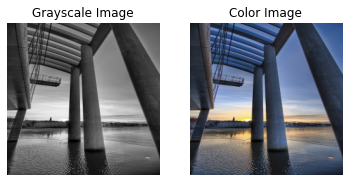

In [6]:
#img_lab = np.concatenate((ab[0],l[0][:,:,None]),axis=2)
img_index = 5
lab = createLab(10)
img_lab = lab[img_index]

fig = plt.figure()
fig1 = fig.add_subplot(1, 2, 1)
fig1.title.set_text("Grayscale Image")
plt.axis('off')
plt.imshow(img_lab[:,:,0], cmap='gray')
fig2 = fig.add_subplot(1, 2, 2)
fig2.title.set_text("Color Image")
plt.axis('off')
img_labs = cv2.cvtColor(img_lab,cv2.COLOR_LAB2RGB)
plt.imshow(img_labs)

## Convert Data to Tensors

In [7]:
lab = createLab(200)
labtensor = torch.tensor(lab)

# Adding Noise

In [8]:
T = 1000
diffTerms = util.ConstantDiffusionTerms(T, fp.linear_beta_schedule)

In [9]:
# Creating tensors
t = []
for i in range(0, T, round(T/8)):
    t.append(torch.tensor([i]))
t.append(torch.tensor([T-1]))

# Grabbing image
img_rgb = cv2.cvtColor(lab[img_index],cv2.COLOR_LAB2RGB)

# RESIZE
# img_rgb = cv2.resize(img_rgb, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

# Normalizing image to [-1,1] and converting to tensor:
img_rgb = cv2.normalize(img_rgb, None, alpha = -1, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
img_rgb = torch.tensor(img_rgb)
img_rgb = rearrange(img_rgb,"w h c-> 1 c w h")
print(img_rgb.shape)

# Adding Noise for each t
noisy_img = []
for i in t:
    noisy = fp.q_sample(img_rgb, i, diffTerms)
    noisy = rearrange(noisy,"1 c w h-> w h c")
    noisy_img.append(noisy.clone().detach().numpy())

# Normalizing to [0,255] in order to display it:
norm_img = []
for i in noisy_img:
    norm = cv2.normalize(i, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_img.append(norm.astype("uint8"))

torch.Size([1, 3, 224, 224])


## Let's see if our noise scheduler works

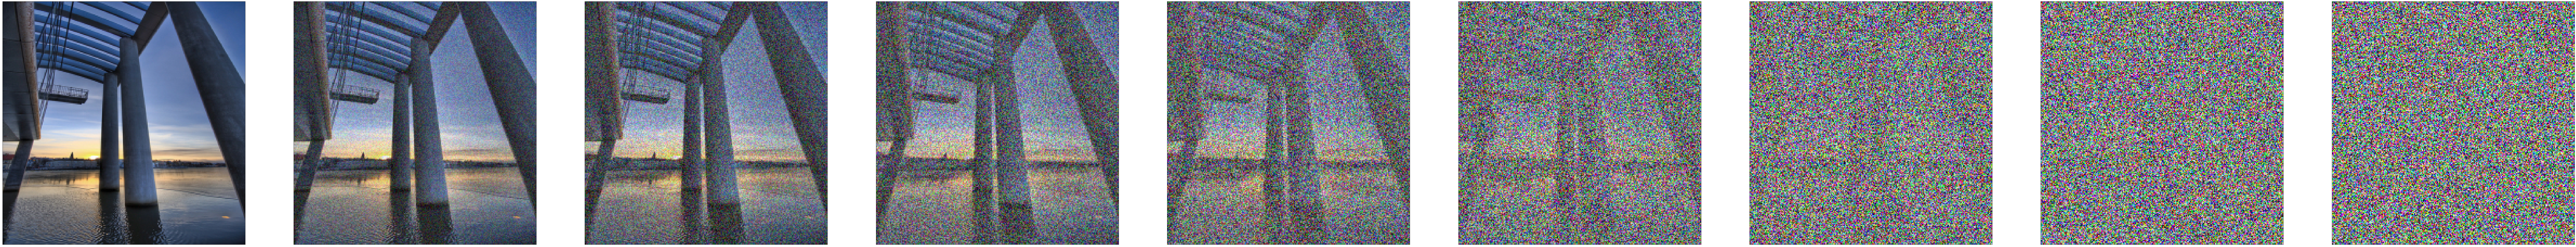

In [10]:
if not isinstance(norm_img[0], list):
    norm_img = [norm_img]

num_rows = len(norm_img)
num_cols = len(norm_img[0])
fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)

for row_idx, row in enumerate(norm_img):
    row = row
    for col_idx, img in enumerate(row):
        ax = axs[row_idx, col_idx]
        ax.imshow(np.asarray(img))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Success!